This is an online retail dataset, which contains data about a companies sales online from 2011. It would appear they sell household items. This company sells worldwide but a significant portion of their sales are UK, compromising 91% of the transactions. The rest are split up between other countries in Europe and the Americas. In this instance, we’ll analyse the data for Ireland and check for seasonality before running the predictive algorithms. Firstly, let's import the libraries, dataset and see what the data contains.

In [1]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings 
warnings.filterwarnings("ignore")

In [2]:
online_retail=pd.read_excel('online retail.xlsx', index_col = 'InvoiceDate',
                 parse_dates = True)
online_retail.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 541909 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   UnitPrice    541909 non-null  float64
 5   CustomerID   406829 non-null  float64
 6   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [3]:
online_retail.head(10)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,7.65,17850.0,United Kingdom
2010-12-01 08:26:00,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,17850.0,United Kingdom
2010-12-01 08:28:00,536366,22633,HAND WARMER UNION JACK,6,1.85,17850.0,United Kingdom
2010-12-01 08:28:00,536366,22632,HAND WARMER RED POLKA DOT,6,1.85,17850.0,United Kingdom


In [4]:
online_retail['Country'].unique() # What countries does it sell into.

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [5]:
online_retail=online_retail.query("Country == 'EIRE'") # Use sales from Ireland.
online_retail.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8196 entries, 2010-12-01 14:05:00 to 2011-12-08 15:54:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    8196 non-null   object 
 1   StockCode    8196 non-null   object 
 2   Description  8196 non-null   object 
 3   Quantity     8196 non-null   int64  
 4   UnitPrice    8196 non-null   float64
 5   CustomerID   7485 non-null   float64
 6   Country      8196 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 512.2+ KB


In [6]:
online_retail.isnull().sum() # check for null values

InvoiceNo        0
StockCode        0
Description      0
Quantity         0
UnitPrice        0
CustomerID     711
Country          0
dtype: int64

There are 711 rows that contain a null value in CustomerId. Let's drop those.

In [7]:
online_retail['CustomerID'].dropna

<bound method Series.dropna of InvoiceDate
2010-12-01 14:05:00    14911.0
2010-12-01 14:05:00    14911.0
2010-12-01 14:05:00    14911.0
2010-12-01 14:05:00    14911.0
2010-12-01 14:05:00    14911.0
                        ...   
2011-12-08 15:54:00    14911.0
2011-12-08 15:54:00    14911.0
2011-12-08 15:54:00    14911.0
2011-12-08 15:54:00    14911.0
2011-12-08 15:54:00    14911.0
Name: CustomerID, Length: 8196, dtype: float64>

Now we need to summarise the sale data based on total sum of quantites and average price. This dataset will then be used to perform the predictions.

In [8]:
online_retail_subset = online_retail[['Quantity', 'UnitPrice']]
online_retail_daily = online_retail_subset.resample('D').agg({'Quantity': 'sum', 'UnitPrice': 'mean'})
online_retail_daily.fillna(method='ffill', inplace=True)
online_retail_daily.head()

,Quantity,UnitPrice
InvoiceDate,,
2010-12-01,243,6.363810
2010-12-02,4,3.750000
2010-12-03,2575,3.985412
2010-12-04,0,3.985412
2010-12-05,0,3.985412


In [9]:
online_retail_subset = online_retail[['Quantity', 'UnitPrice']]
online_retail_daily = online_retail_subset.resample('D').agg({'Quantity': 'sum', 'UnitPrice': 'mean'})
online_retail_daily.fillna(method='ffill', inplace=True)

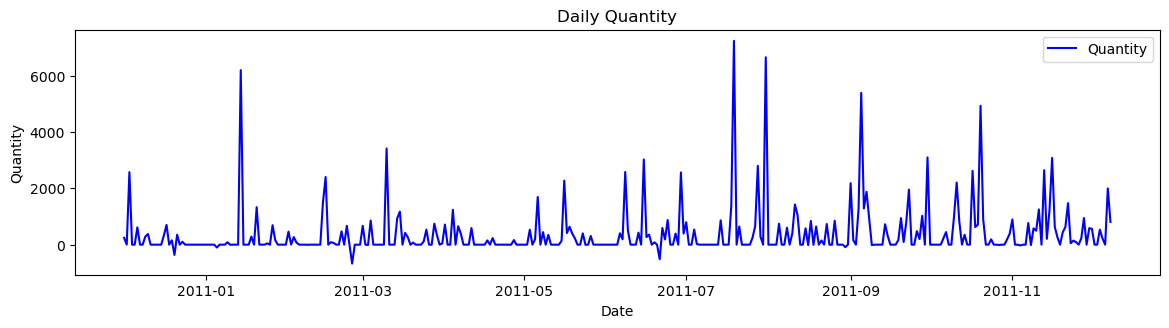

In [10]:
#Plotting the time series data to see the trends: Quantity
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(online_retail_daily['Quantity'], label='Quantity', color='blue')
plt.title('Daily Quantity')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

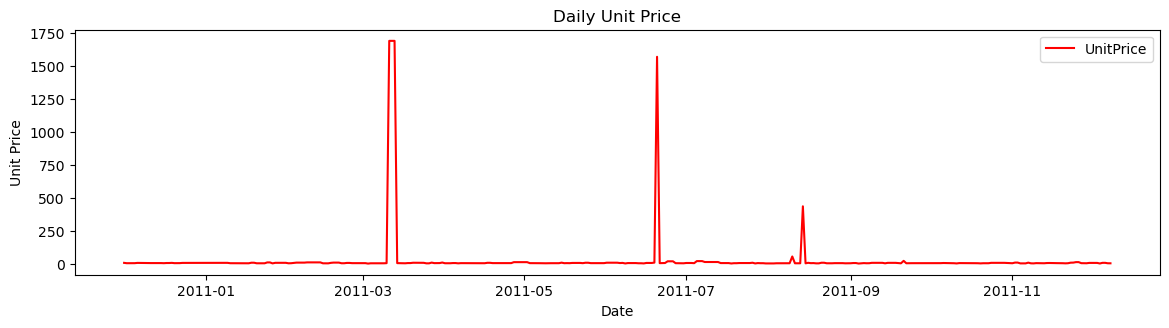

In [11]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 2)
plt.plot(online_retail_daily['UnitPrice'], label='UnitPrice', color='red')
plt.title('Daily Unit Price')
plt.xlabel('Date')
plt.ylabel('Unit Price')
plt.legend()

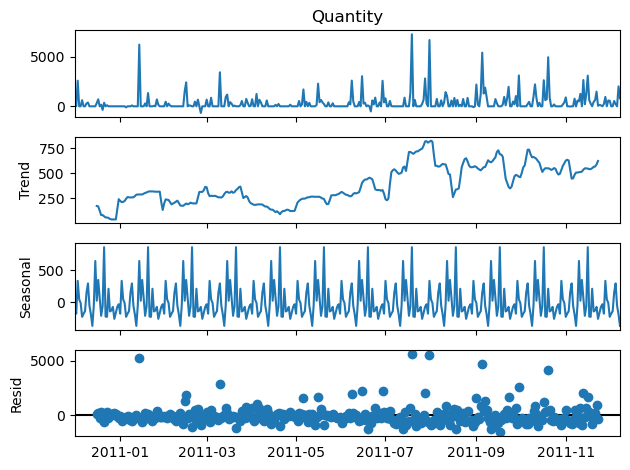

In [12]:
#Decomposing Quantity
decomposition_quantity = seasonal_decompose(online_retail_daily['Quantity'], model='additive', period=30)
decomposition_quantity.plot()
plt.show()

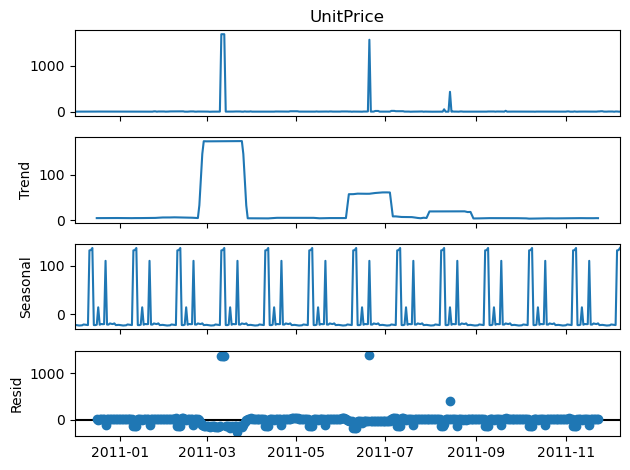

In [13]:
# Decomposing Price
decomposition_price = seasonal_decompose(online_retail_daily['UnitPrice'], model='additive', period=30)
decomposition_price.plot()
plt.show()

Looking at the daily retail graph, there are quite a few spikes in it, especially at the latter end of the year indicating perhaps some seasonality as Christmas approaches. We’ll use the Ducky Fuller algorithm to calculate a p value. Anything less than 0.05 indicates seasonality. The p value in this instance is 2.6x10-30 . This value is quite a bit below 0.05 which confirms the data is seasonal. We will use the SARIMAX algorithm.

We’ll firstly look at the visualisations to see what they tell us:


In [14]:
# Applying Ducky Fuller test to see the seasonality of the data: Quantity

#H0: data is not seasonal
#H1: data is seasonal

result_quantity = adfuller(online_retail_daily['Quantity'])
print('p-value for Quantity:', result_quantity[1])

p-value for Quantity: 2.6032908157584725e-30


In [15]:
train_size = int(len(online_retail_daily) * 0.8)
train, test = online_retail_daily.iloc[:train_size], online_retail_daily.iloc[train_size:]

In [16]:
order_quantity = (1, 1, 1)  
model_quantity = SARIMAX(train['Quantity'], order=order_quantity)
#Training the model
results_quantity = model_quantity.fit()
results_quantity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Quantity   No. Observations:                  298
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2443.317
Date:                Wed, 04 Sep 2024   AIC                           4892.634
Time:                        09:49:23   BIC                           4903.716
Sample:                    12-01-2010   HQIC                          4897.071
                         - 09-24-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0357      0.067      0.530      0.596      -0.096       0.168
ma.L1         -0.9832      0.014    -70.813      0.000      -1.010      -0.956
sigma2      8.109e+05      2e+04     40.557      0.000    7.72e+05     8.5e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             10591.35
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                             4.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

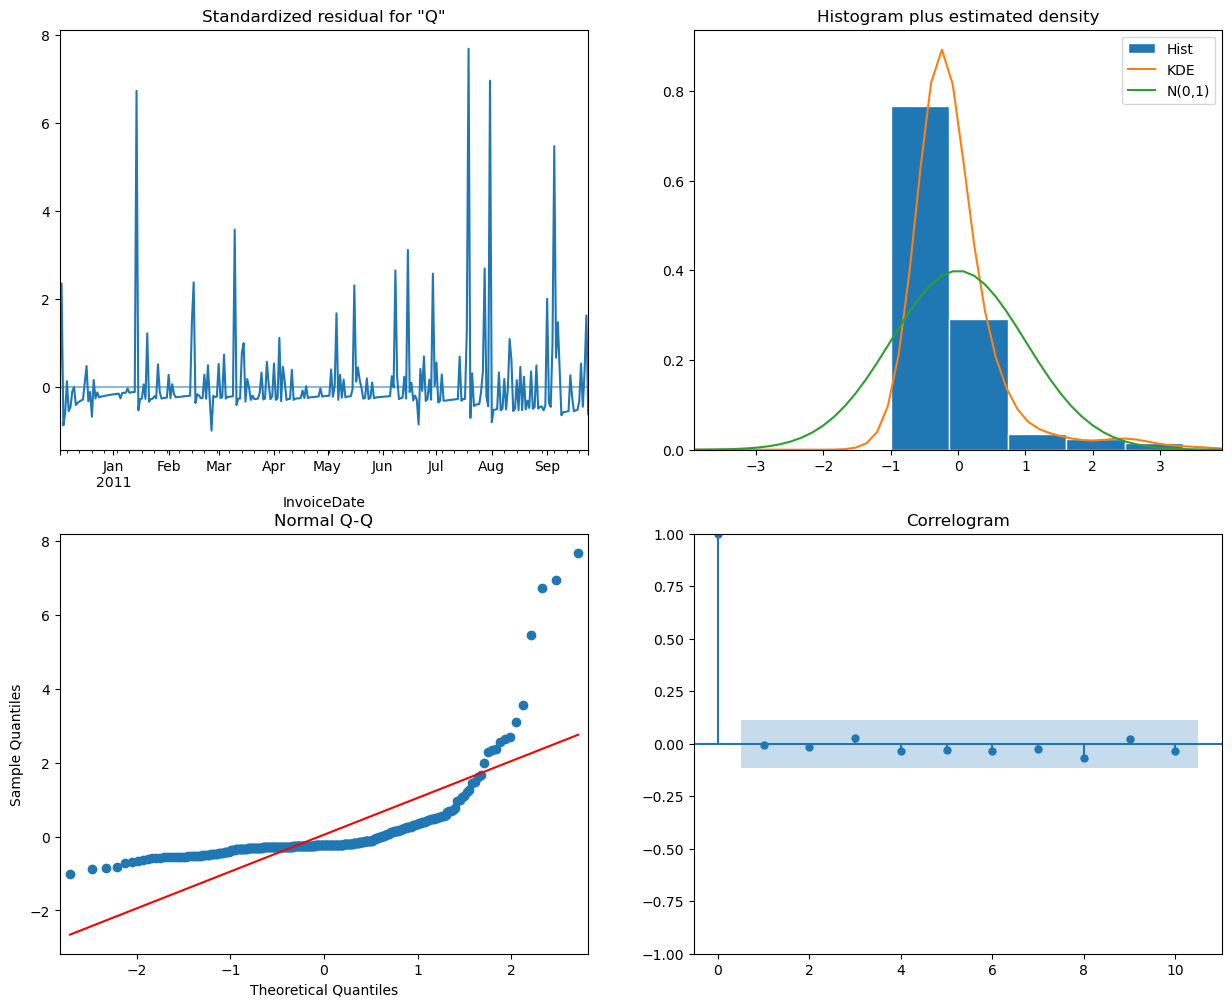

In [17]:
#Diagnostic
results_quantity.plot_diagnostics(figsize=(15, 12))
plt.show()

In [18]:
#Forecasting on the test period
forecast_steps = len(test)
forecast = results_quantity.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
forecast_values.index = test.index

#Accuracy
mae = mean_absolute_error(test['Quantity'], forecast_values).round()
mae



581.0

In [19]:
mse = mean_squared_error(test['Quantity'], forecast_values).round()
mse

799361.0

In [20]:
rmse = np.sqrt(mse).round()
rmse

894.0

In [21]:
#In case there are zeros in the division as before
non_zero_test = test['Quantity'] != 0
filtered_test = test['Quantity'][non_zero_test]
filtered_forecast = forecast_values[non_zero_test]

mape = np.mean((np.abs((filtered_test - filtered_forecast) / filtered_test)) * 100).round()
mape

829.0

In [22]:
# Results of forecasting in table
forecast_df_quantity = pd.DataFrame({
    'Forecast': forecast.predicted_mean.round(),
})
print(forecast_df_quantity)

            Forecast
2011-09-25     486.0
2011-09-26     503.0
2011-09-27     504.0
2011-09-28     504.0
2011-09-29     504.0
...              ...
2011-12-04     504.0
2011-12-05     504.0
2011-12-06     504.0
2011-12-07     504.0
2011-12-08     504.0

[75 rows x 1 columns]


These are the visualisations for the quantity variable. The histogram shows a normal distribution. The correlogram, is fairly normal too with most values being close to the axis of 0. Normal Q-Q is a little out, but follows the line closely. It indicates, once again, the data is seasonal.

Let’s do our first forecast:


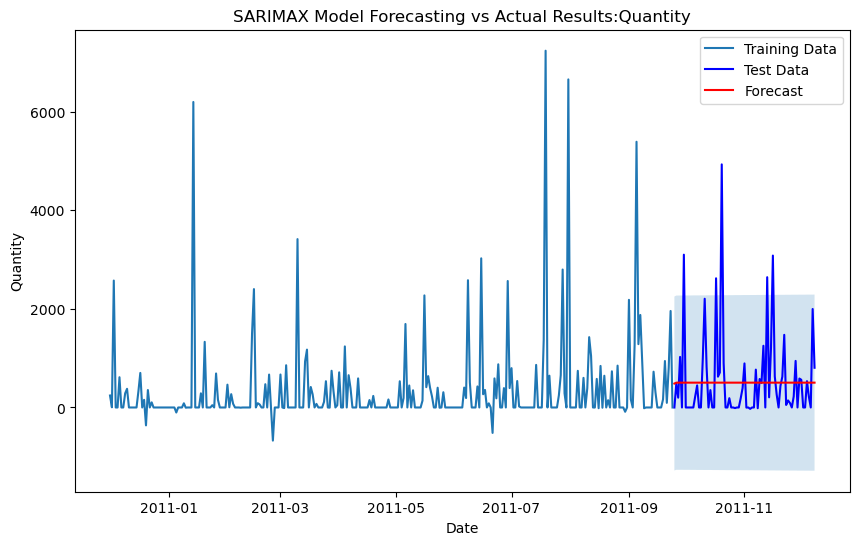

In [23]:
# Comparing actual model with the forecasting
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Quantity'], label='Training Data')
plt.plot(test.index, test['Quantity'], label='Test Data', color='blue')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast.conf_int().index, 
                 forecast.conf_int().iloc[:, 0].round(), 
                 forecast.conf_int().iloc[:, 1].round(), alpha=0.2)
plt.title('SARIMAX Model Forecasting vs Actual Results:Quantity')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

Our forecast area has quite a lot of spikes in it. The actual forecast is a straight line, though it is somewhat lower than the spikes the average would suggest, but in terms of actual forecast, it is a conservative one.

Now let’s look at price.


In [24]:
#Splitting the data into training and test set
train_size = int(len(online_retail_daily) * 0.8)
train, test = online_retail_daily.iloc[:train_size], online_retail_daily.iloc[train_size:]
#Training the model
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 30) #monthly seasonality
model = SARIMAX(train['UnitPrice'], order=order, seasonal_order=seasonal_order)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          UnitPrice   No. Observations:                  298
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood               -1781.733
Date:                            Wed, 04 Sep 2024   AIC                           3573.465
Time:                                    09:49:33   BIC                           3591.401
Sample:                                12-01-2010   HQIC                          3580.670
                                     - 09-24-2011                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5114      0.017     30.844      0.000       0.479       0.544
ma.L1         -1.0000     23.190     -0.043      0.966     -46.452      44.452
ar.S.L30      -0.0243      0.049     -0.497      0.620      -0.120       0.072
ma.S.L30      -0.9996     23.213     -0.043      0.966     -46.496      44.496
sigma2      2.766e+04      0.000   1.21e+08      0.000    2.77e+04    2.77e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             24128.05
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                             4.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+26. Standard errors may be unstable.
"""

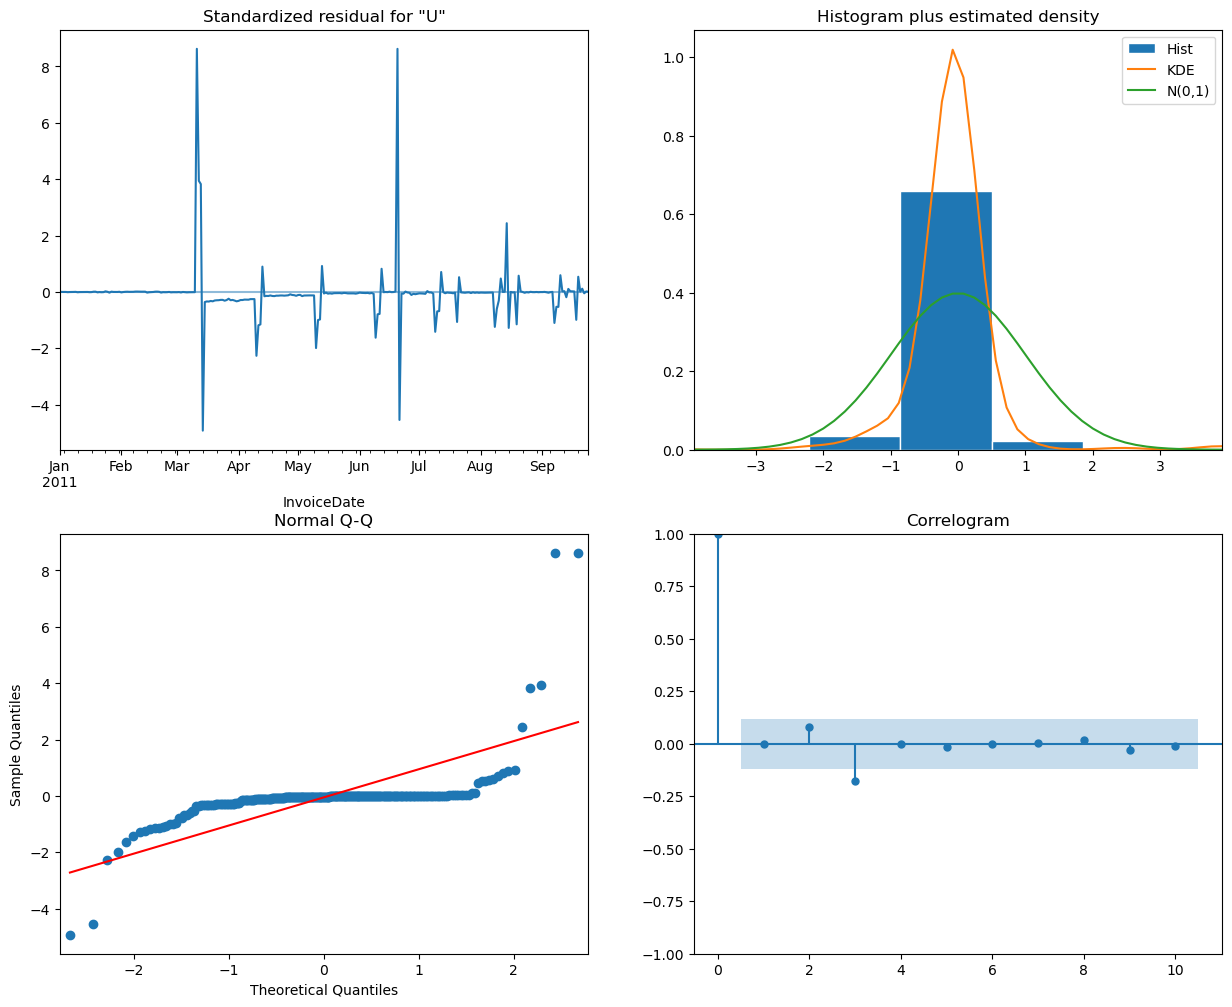

In [25]:
#Diagnostic
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [26]:
#Forecasting on the test period
forecast_steps = len(test)
forecast = results.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
forecast_values.index = test.index

#Avoiding zeros in the denominator

non_zero_test = test['UnitPrice'] != 0
filtered_test = test['UnitPrice'][non_zero_test]
filtered_forecast = forecast_values[non_zero_test]

mape = np.mean(np.abs((filtered_test - filtered_forecast) / filtered_test)) * 100
mape

789.8088612713209

In [27]:
#Results in a table
forecast_df = pd.DataFrame({
    'Forecast': forecast.predicted_mean,
})
print(forecast_df)

              Forecast
2011-09-25   -0.216955
2011-09-26   -1.095086
2011-09-27   -1.633482
2011-09-28   -2.714414
2011-09-29   -3.235023
...                ...
2011-12-04   -4.522247
2011-12-05   -5.074340
2011-12-06  163.387831
2011-12-07  163.412381
2011-12-08  168.749657

[75 rows x 1 columns]


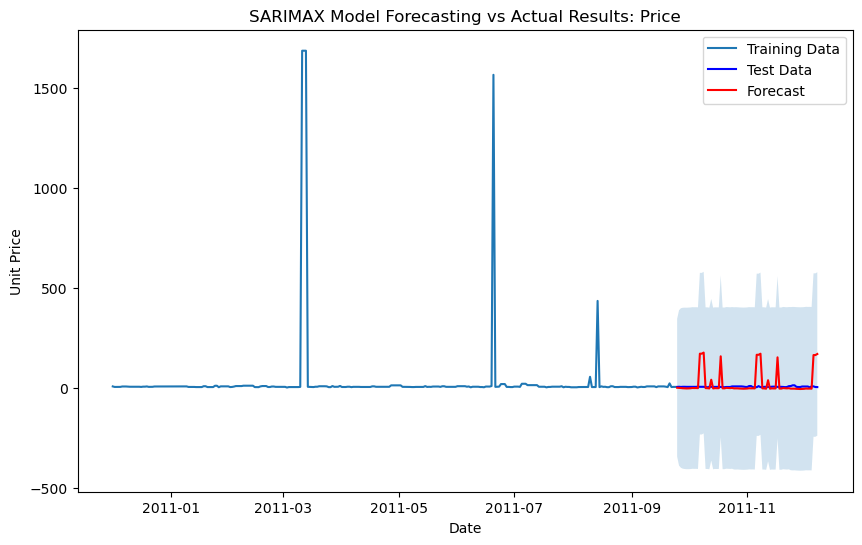

In [28]:
#Comparing actual results with forecasting values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['UnitPrice'], label='Training Data')
plt.plot(test.index, test['UnitPrice'], label='Test Data', color='blue')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast.conf_int().index, 
                 forecast.conf_int().iloc[:, 0], 
                 forecast.conf_int().iloc[:, 1], alpha=0.2)
plt.title('SARIMAX Model Forecasting vs Actual Results: Price')
plt.xlabel('Date')
plt.ylabel('Unit Price')
plt.legend()
plt.show()

The forecast this time around has spikes in it as does the training data. The quantities for forecast were a bit on the conservative side. It appears to be the same for price landing somewhere midway between the test and training data. Now lets do a 10 day forecast

In [29]:
#Forecasting for the next 10 days: Fit the model with the full dataset
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 30)
model = SARIMAX(online_retail_daily['UnitPrice'], order=order, seasonal_order=seasonal_order)
results = model.fit()

In [30]:
#Defining the time period
forecast_steps = 10
forecast = results.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

#Future dates for the forecast
last_date = online_retail_daily.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

#Results in a table for confidence intervals and forecasting
forecast_df = pd.DataFrame({
    'Forecast': forecast_values,
    'Lower CI': forecast_ci.iloc[:, 0],
    'Upper CI': forecast_ci.iloc[:, 1]
}, index=future_dates)
forecast_df

,Forecast,Lower CI,Upper CI
2011-12-09,-80.480081,-384.819780,223.859618
2011-12-10,-48.273299,-391.199944,294.653346
2011-12-11,-32.508404,-385.376108,320.359301
2011-12-12,12.057371,-343.641261,367.756002
2011-12-13,-19.794617,-376.371197,336.781963
2011-12-14,-16.130168,-373.008268,340.747931
2011-12-15,-15.299543,-372.293549,341.694463
2011-12-16,-14.598132,-371.641698,342.445434
2011-12-17,117.390502,-239.676421,474.457424
2011-12-18,-15.059257,-372.138657,342.020144


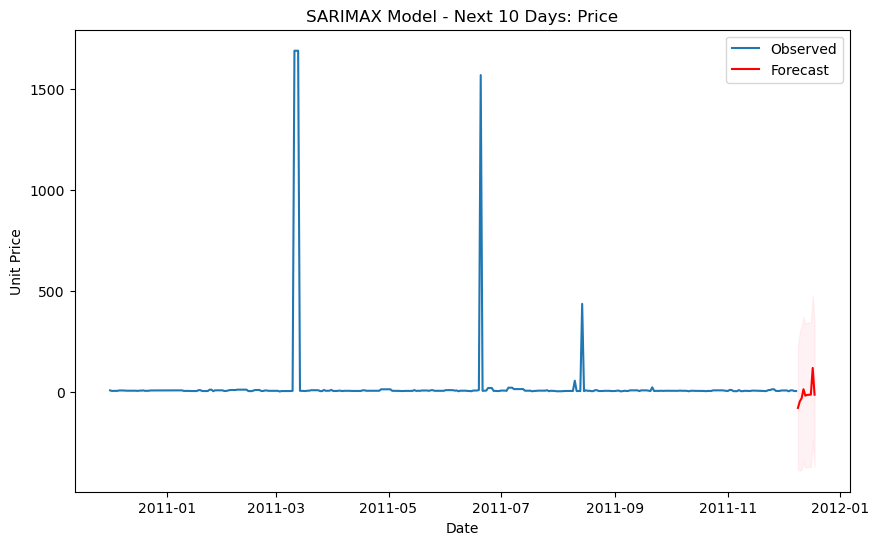

In [31]:
#Results in a visualisation:forecasting
plt.figure(figsize=(10, 6))
plt.plot(online_retail_daily.index, online_retail_daily['UnitPrice'], label='Observed')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, 
                 forecast_df['Lower CI'], 
                 forecast_df['Upper CI'], color='pink', alpha=0.2)
plt.title('SARIMAX Model - Next 10 Days: Price')
plt.xlabel('Date')
plt.ylabel('Unit Price')
plt.legend()
plt.show()

The forecast is for the first 10 days of January. Given the seasonal nature of the trade with this company, it is pretty low. As a result, it could be accurate as spending once the Christmas period is over tends to drop quite considerably.  